In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import scvelo as scv
import scanpy as sc

import spliceJAC as sp

---

0) Load the data

---

We consider a pancreatic endocrinogenesis dataset (original publication is available at https://journals.biologists.com/dev/article/146/12/dev173849/19483). 

We can import the dataset using the standard scanpy.read_h5ad() function. A version of this dataset is available in the datasets/Pancreas folder.

In [5]:
panc_data = sc.read_h5ad('datasets/Pancreas/pancreas.h5ad')

We can visualize the data in a 2D UMAP space with the "umap_scatter" plot function. 

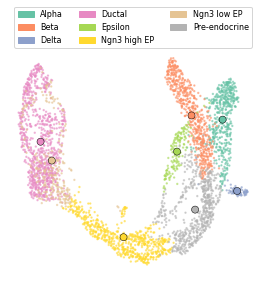

In [6]:
sp.pl.plots.umap_scatter(panc_data, fontsize=8, ncol=3, figname='results/pancreas/umap.pdf')

We first filter the data, compute the velocity graph and PAGA trajectories. This part of the tutorial is same as in the original scVElo tutorial on the same dataset available at https://scvelo.readthedocs.io/VelocityBasics/

In [7]:
scv.pp.filter_genes(panc_data, min_shared_counts=20)
scv.pp.normalize_per_cell(panc_data)
scv.pp.filter_genes_dispersion(panc_data, n_top_genes=2000)
scv.pp.log1p(panc_data)

Filtered out 55 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.


In [7]:
scv.tl.velocity(panc_data)
scv.tl.velocity_graph(panc_data)

computing neighbors
    finished (0:00:12) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:13) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [8]:
panc_data.uns['neighbors']['distances'] = panc_data.obsp['distances']
panc_data.uns['neighbors']['connectivities'] = panc_data.obsp['connectivities']

In [9]:
scv.tl.paga(panc_data, groups='clusters')

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


We add the dataframe with PAGA trajectories in panc_data.uns['PAGA_paths'] to be used later in the  transition analysis:

In [34]:
panc_data.uns['PAGA_paths'] = scv.get_df(panc_data, 'paga/transitions_confidence', precision=2).T

Inference with PAGA highlights a total of 7 transitions:

In [22]:
panc_data.uns['PAGA_paths']

,Ductal,Ngn3 low EP,Ngn3 high EP,Pre-endocrine,Beta,Alpha,Delta,Epsilon
Ductal,0.0,0.1,0.00,0.00,0.0,0.00,0.00,0.00
Ngn3 low EP,0.0,0.0,0.24,0.00,0.0,0.00,0.00,0.00
Ngn3 high EP,0.0,0.0,0.00,0.25,0.0,0.00,0.00,0.00
Pre-endocrine,0.0,0.0,0.00,0.00,0.6,0.16,0.17,0.12
Beta,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00
Alpha,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00
Delta,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00
Epsilon,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00


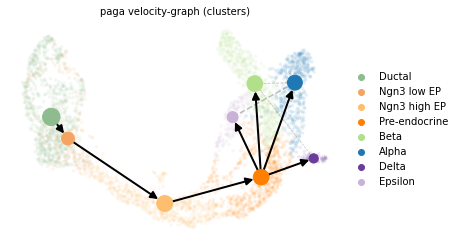

In [23]:
scv.pl.paga(panc_data, basis='umap', size=50, alpha=.1, min_edge_width=2, node_size_scale=1.5)

---

1) Run the spliceJAC inference

---

We can run the spliceJAC inference step by simply calling the "estimate_jacobian" function.  

Here, we choose to select n=50 highly variable genes for gene-gene interaction regression.

In [14]:
sp.tl.inference.estimate_jacobian(panc_data, n_top_genes=50)

Filtered out 55 genes that are detected 20 counts (shared).
Extracted 50 highly variable genes.
Running quick regression...
Running subset regression on the Ngn3 high EP cluster...
Running subset regression on the Delta cluster...
Running subset regression on the Pre-endocrine cluster...
Running subset regression on the Beta cluster...
Running subset regression on the Alpha cluster...
Running subset regression on the Ngn3 low EP cluster...
Running subset regression on the Epsilon cluster...
Running subset regression on the Ductal cluster...


---

2) Analysis of interactions in individual cell states

---

First, we compute the statistics on the cell state-specific Gene Regulatory Networks inferred by spliceJAC:

In [15]:
sp.tl.analysis.grn_statistics(panc_data)

A regulatory network of cell state-specific interactions can be visualized with the "visualize_network" function. For instance, here we visualize the core GRN of the Ductal cell state. The number of interactions can be increased or decreased by changing the weight_quantile argument.

There exist multiple connected components. Choose the parameter cc_id to show other components


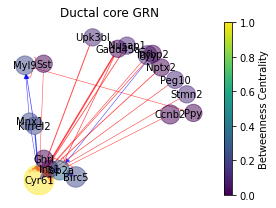

In [16]:
sp.pl.plots.visualize_network(panc_data, 'Ductal', weight_quantile=.975, plot_interactive=False, node_color='centrality', figname='results/pancreas/ductal_GRN.pdf')

The GRN can be visualized in an interactive form by setting plot_interactive=True. This command needs to be run to enjoy the interactive network.

There exist multiple connected components. Choose the parameter cc_id to show other components


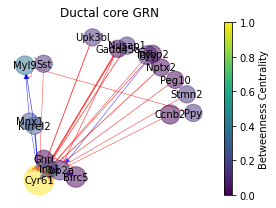

In [17]:
sp.pl.plots.visualize_network(panc_data, 'Ductal', weight_quantile=.975, plot_interactive=True, node_color='centrality', figname='results/pancreas/ductal_GRN.pdf')

To estimate the signaling roles of genes in each cell state, we first run the "signaling_score" function

In [18]:
sp.tl.analysis.signaling_score(panc_data)

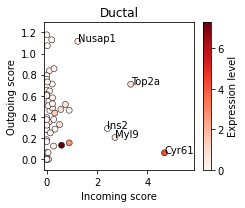

In [19]:
sp.pl.plots.plot_signaling_hubs(panc_data, 'Ductal', figname='results/pancreas/Ductal_hubs.pdf')

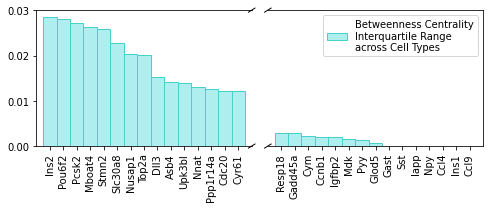

In [20]:
sp.pl.plots.gene_variation(panc_data, method='inter_range', figname='results/pancreas/node_variability.pdf', figsize=(7, 3))

---

3) Analysis of transitions

---

We can use the rank_genes_groups scanpy function to identify DEG of each cell state:

In [24]:
sc.tl.rank_genes_groups(panc_data, 'clusters', method='t-test')

With the trans_from_PAGA function, we can identify the important transition driver genes and their connections to important DEGs for each transition identified by PAGA:

In [35]:
sp.tl.analysis.trans_from_PAGA(panc_data)

First, we can visualize the change in signaling roles upon transition, in this case for the switch from Ductal to Ngn3 low EP:

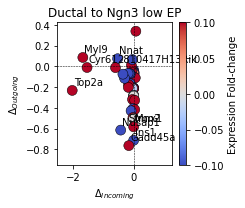

In [26]:
sp.pl.plots.plot_signaling_change(panc_data, 'Ductal', 'Ngn3 low EP',figname='results/pancreas/ductal_to_lowEP_sign_change.pdf')

Moreover, the core_GRN function shows the connections between the DEGs of the starting state (Ductal) and the important transitino driver genes leading to the Ngn3 low EP state:

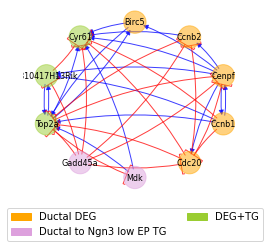

In [27]:
sp.pl.plots.core_GRN(panc_data, 'Ductal', 'Ngn3 low EP', figname='results/pancreas/Ductal_to_lowEP_GRN.pdf', figsize=(4,4))

We can also visualize the top transition driver genes ranked basd on instability score (higher score implies a major role in the transition):

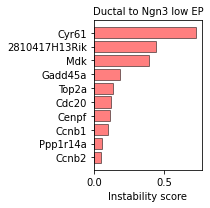

In [28]:
sp.pl.plots.plot_trans_genes(panc_data, 'Ductal', 'Ngn3 low EP', figname='results/pancreas/Ductal_to_lowEP_genes.pdf')

Finally, we can compare the instability scores with the DEG scores computed by scanpy to visualize important genes that are not identified with previous DEG-based methods:

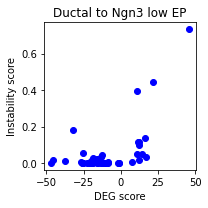

In [29]:
sp.pl.plots.scatter_scores(panc_data, 'Ductal', 'Ngn3 low EP', figname='results/pancreas/Ductal_to_lowEP.pdf')

---

4) Differentiation from the Pre-endocrine state

---

In [33]:
sp.pl.sankey_plots.tg_bif_sankey(panc_data, 'Pre-endocrine', ['Alpha', 'Beta', 'Delta', 'Epsilon'], figname='results/pancreas/sankey.pdf')

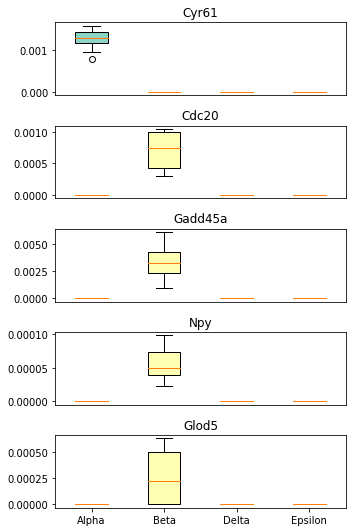

In [32]:
sp.pl.plots.compare_standout_genes(panc_data, cluster_list=['Alpha', 'Beta', 'Delta', 'Epsilon'], figname='results/pancreas/bif_between.pdf', ylabel=False)